#### Reading the training data

In [2]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cars=None
notcars=None
cars = glob.glob('training_data/vehicles/**/*.png')
notcars = glob.glob('training_data/non-vehicles/**/*.png')
print( len(cars), len(notcars) )

8792 8968


##### Tested data augmentation, but not used 

In [33]:
# # data augmentation
# import numpy as np
# import math
# from sklearn.utils import shuffle


# # Functions for Geometric Transformations of Image
# def translation_image(img, translation_lbound, translation_hbound):
#     del_x, del_y = np.random.randint(translation_lbound, translation_hbound, 2)
#     M = np.float32([[1, 0, del_x], [0, 1, del_y]])
#     dst = cv2.warpAffine(img, M, (img.shape[0], img.shape[1]))
#     return dst

# # It changes the image to give a top-view of the image
# def perspectiveTransformation_image(img):
#     w = img.shape[0]
#     h = img.shape[1]
#     hbound = random.randint(24, h)
#     lbound = random.randint(0, 10)
#     points_a = np.float32([[0,0],[w,0],[0,h],[w,h]])
#     points_b = np.float32([[0, 0], [hbound, lbound], [lbound, h],[w, hbound]])
#     M = cv2.getPerspectiveTransform(points_a, points_b)
#     dst = cv2.warpPerspective(img, M, (w,h))
#     return dst
    
# # Rotates the image
# def rotation_image(img, rotation_lbound, rotation_hbound ):
#     w = img.shape[0]
#     h = img.shape[1]
#     angle = random.randint(rotation_lbound, rotation_hbound)
#     M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
#     dst = cv2.warpAffine(img, M, (w, h))
#     return dst

In [2]:

# # array to contain new augmented images
# cars_images = []
# notcars_images = []

# # Translation lower and higher bound values
# l = -2.5
# h = 7
# # Rotation lower and higher bound values
# rlb = -30
# rhb = 30                       

# for c in cars:
#     im = mpimg.imread(c)
#     cars_images.append(im)
#     cars_images.append(translation_image(im, l, h))
#     cars_images.append(rotation_image(im, rlb, rhb))
#     cars_images.append(perspectiveTransformation_image(im))

# for nc in notcars:
#     im = mpimg.imread(nc)
#     notcars_images.append(im)
#     notcars_images.append(translation_image(im, l, h))
#     notcars_images.append(rotation_image(im, rlb, rhb))
#     notcars_images.append(perspectiveTransformation_image(im))

# print(len(cars_images), len(notcars_images))


8792 8968


##### Generating more images (run only once)

In [ ]:
import cv2

# capture image at time t[i]
t = [9000,28000, 28500, 29000, 28750, 37000, 41000, 42000, 43000, 45000, 49000, 50000]
vidcap = cv2.VideoCapture('project_video.mp4')
for i in range(0,len(t)):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,t[i])      # just cue to 20 sec. position
    success,image = vidcap.read()
    fname = "frame"+str(t[i])+".jpg"
    if success:
        cv2.imwrite(fname, image)     # save frame as JPEG file

######  Displaying sample images from two classes : _Cars_ and _Non-Cars_

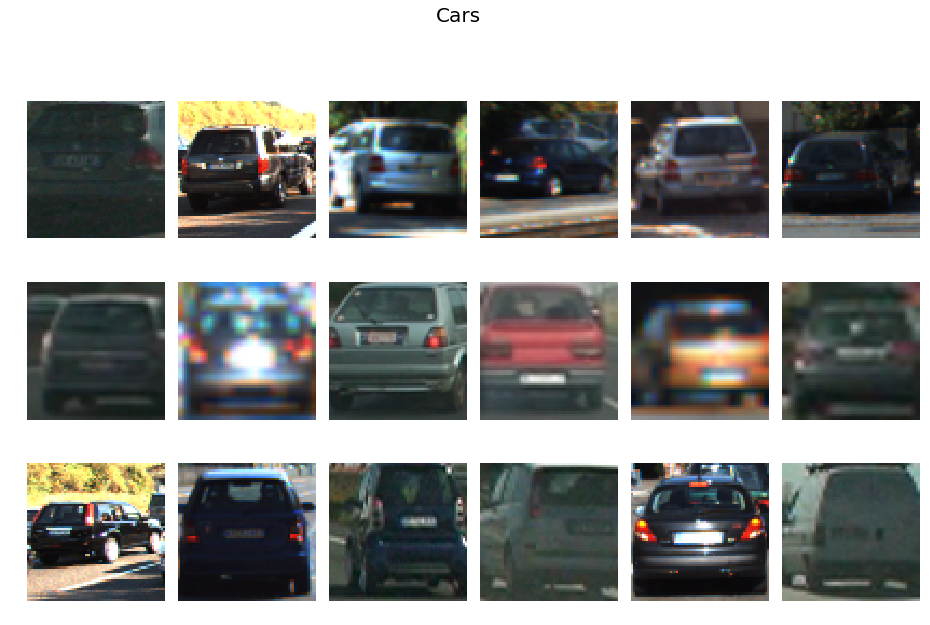

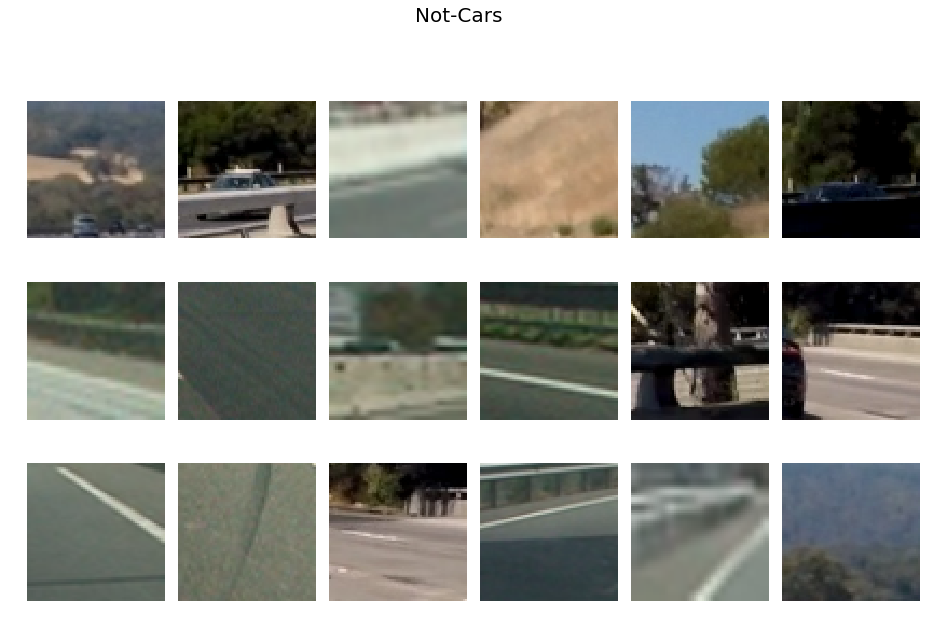

In [4]:
import cv2
import numpy as np

n = 18 # number of examples from each class to display

plt.clf()

fig_cars = plt.figure(figsize=(16, 10))
fig_cars.subplots_adjust(hspace = 0.0001, wspace=.1)
fig_cars.suptitle('Cars', fontsize=20)

#axs_cars = axs_cars.ravel()

fig_ncars = plt.figure(figsize=(16, 10))
fig_ncars.subplots_adjust(hspace = 0.0001, wspace=.1)
fig_ncars.suptitle('Not-Cars', fontsize=20)

#axs_ncars = axs_ncars.ravel()

for i in range(n):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    ax = fig_cars.add_subplot(3,6,i+1)
    ax.imshow(img)
    ax.axis('off')

for j in range(n):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    ax = fig_ncars.add_subplot(3,6,j+1)
    ax.imshow(img)
    ax.axis('off')

plt.show()

fig_cars.savefig("./output_images/car_class.png")
fig_ncars.savefig("./output_images/ncar_class.png")

#### Feature extraction

We have defined two helper functions:

**1. get_hog_features** : get the HOG features from a single image

**2. extract_features** : function to go over all the images and return a feature vector

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orient, (pix_per_cell,pix_per_cell),
        (cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, (pix_per_cell,pix_per_cell),
        (cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        return features

/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


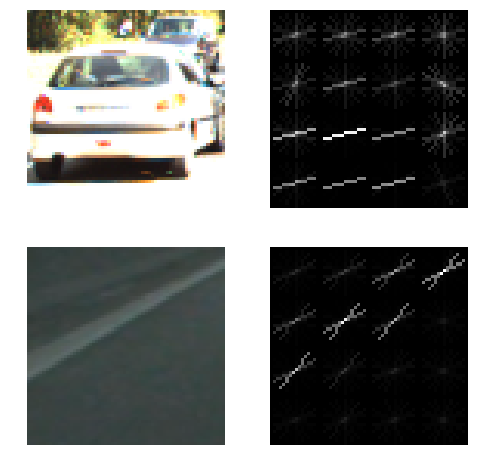

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog


# Define HOG parameters                
orient = 9
pix_per_cell = 16
cell_per_block = 2
ind = np.random.randint(0, len(cars))            
            

# Read in the image
car_image = mpimg.imread(cars[ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_image = mpimg.imread(notcars[ind])
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


img_array = [car_image, notcar_image]
hog_array = [car_hog_image, notcar_hog_image]

# Plot the examples
plt.clf()
fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.ravel()
k=0

for img, hog in zip(img_array, hog_array):
    axs[k].imshow(img)
    axs[k].axis('off')
    axs[k+1].imshow(hog, cmap='gray' )
    axs[k+1].axis('off')
    k+=2
        
plt.show()

fig.savefig("./output_images/hog_gray.png")

In [6]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # apply color conversion if other than 'RGB'
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        vis=False, feature_vec=True)
            hog_features = np.ravel(hog_features)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
# Feature extraction

c_space = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

car_features = extract_features(cars, cspace = c_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, cspace=c_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


X = np.vstack((car_features, notcar_features)).astype(np.float64)  
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Train a Linear SVM classifer

In [8]:
svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9809


In [10]:
'''
find_cars: will run the classifier on the image between 'ystart' and 'ystop' on multiple scales.
the last argument 'show_all_windows' is for diagnostic purposes.
'''

def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, show_all_windows=False):
    
    boxes = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
    
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)  + 1
    nyblocks = (ch1.shape[0] // pix_per_cell)  + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL' :
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb*cells_per_step
            ypos = yb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            hog_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes

In [12]:
'''
Method to draw boxes on the image. Use color = 'random' for better visualization
while testing ystart, ystop, scale etc.
'''
def draw_boxes(img, bboxes, color, thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    new_color = color
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if color == 'random':
            new_color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(imcopy, bbox[0], bbox[1], new_color, thick)
    # Return the image copy with boxes drawn
    return imcopy

###### Very basic testing of window limits and classifier

/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


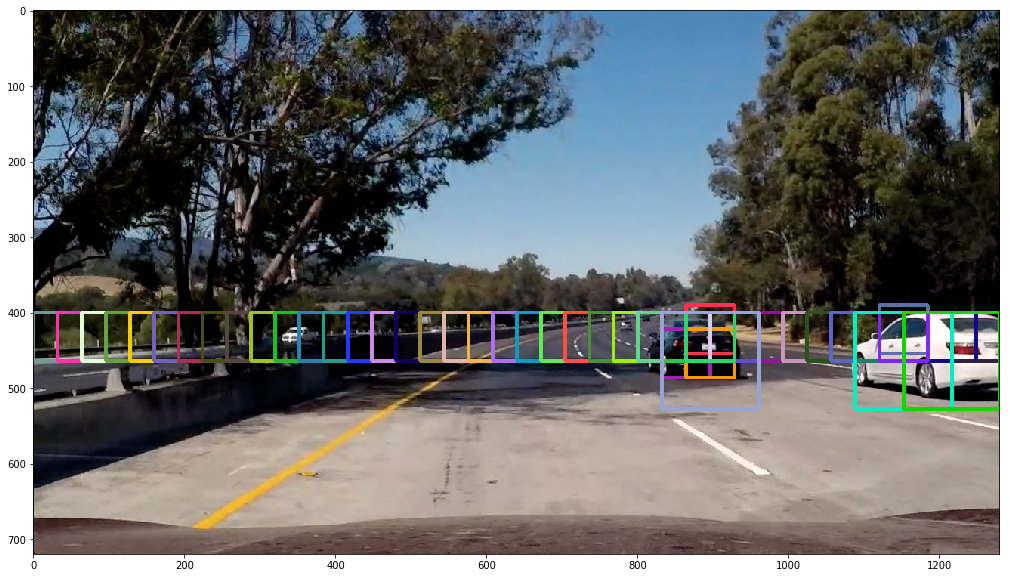

In [19]:
# Testing the ystart, ystop, scale values on all test_images <test1 ... 5>

test_img = mpimg.imread('./test_images/test5.jpg')

cspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' 

boxes = []

params = [(390,518,1,False), (400,548,3, False), (400, 464,1, True),
          (400,560,1,False), (450,642,2,False),(400,656,2,False), (450,578,2,False),
          (390,646,3,False),(400,700,2.5,False)]

for p in params:
    boxes.append(find_cars(test_img, p[0], p[1], p[2], cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, p[3]))

plt.clf()

box_list = [item for sublist in boxes for item in sublist]
test_img_with_boxes = draw_boxes(test_img, box_list, color='random', thick=3)
f, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(test_img_with_boxes)

plt.show()

f.savefig("./output_images/find_cars_b.png")

In [11]:
# ##### Test a setting for all images
# def test_params(img, ystart=400, ystop=464, scale=1):
#     cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#     orient = 11
#     pix_per_cell = 16
#     cell_per_block = 2
#     hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

#     boxes = []
#     boxes.append(find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False))
    
#     plt.clf()

#     box_list = [item for sublist in boxes for item in sublist]
#     final_img = draw_boxes(img, box_list, color=(0,0,255), thick=3)
#     return final_img

In [ ]:
# # Testing combinations of ystart, ystop, scale 
# title = []
# res = []
# ystart = 400
# ystop = 464
# scale = 1
# for f in frames:
#     title.append(f.split('/')[2])
#     img = mpimg.imread(f)
#     res.append(test_params(img, ystart, ystop, scale))


# plt.clf()
# f, axs = plt.subplots(9, 2, figsize=(120,100))
# f.subplots_adjust(right = 0.35,left= 0.20, top = 0.9, bottom=0.45)
# axs = axs.ravel()

# i=0
# for t,im in zip(title, res):
#     axs[i].imshow(im) 
#     axs[i].set_title(t)
#     axs[i].axis('off')
#     i+=1
    
# plt.show()


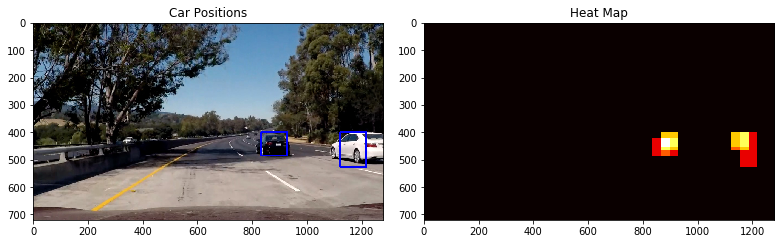

In [16]:
# Functions from lesson# 37 (Multiple detections and flase positives)

from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# 'heating up' (pun intented!) test_img
heat = np.zeros_like(test_img[:,:,1]).astype(np.float)

# get heat image by adding heat to all the boxes identified
heat_image = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat_image = apply_threshold(heat,1)

heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

plt.clf()
fig = plt.figure(figsize=(11,11))

plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.show()

fig.savefig("./output_images/heat_img.png")

In [17]:
# Defining a 'pipeline' to be tested on all test images and video frames. f ----> is the input image


def getProspectiveBoxlist(frame_img):
    boxes = []
    
    cspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'

    
    params = [(390,518,2,False), (400,548,3, False),(400,464,1,False),(416,480,1,False),
              (400,560,2,False), (450,642,2,False),(400,656,2,False), (450,578,2,False),(432,528,1.5,False),
              (400,528,2,False), (390,646,1.5,False),(400,700,2.5,False),(400,596,3.5,False)]

    for p in params:
        boxes.append(find_cars(frame_img, p[0], p[1], p[2], cspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, p[3]))

    box_list = [item for sublist in boxes for item in sublist] 
    return box_list


def findCarsInFrame(img_in):
    
    # Get the list of prospective boxes where the cars may be identified
    box_list = getProspectiveBoxlist(img_in)
    
    # 'heating up' (pun intented!) img_in
    heat = np.zeros_like(img_in[:,:,0]).astype(np.float)

    # get heat image by adding heat to all the boxes identified and return the heat image
    heat_image = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat_image = apply_threshold(heat,1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img_in), labels)
    return draw_img

/Users/pkaul2/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


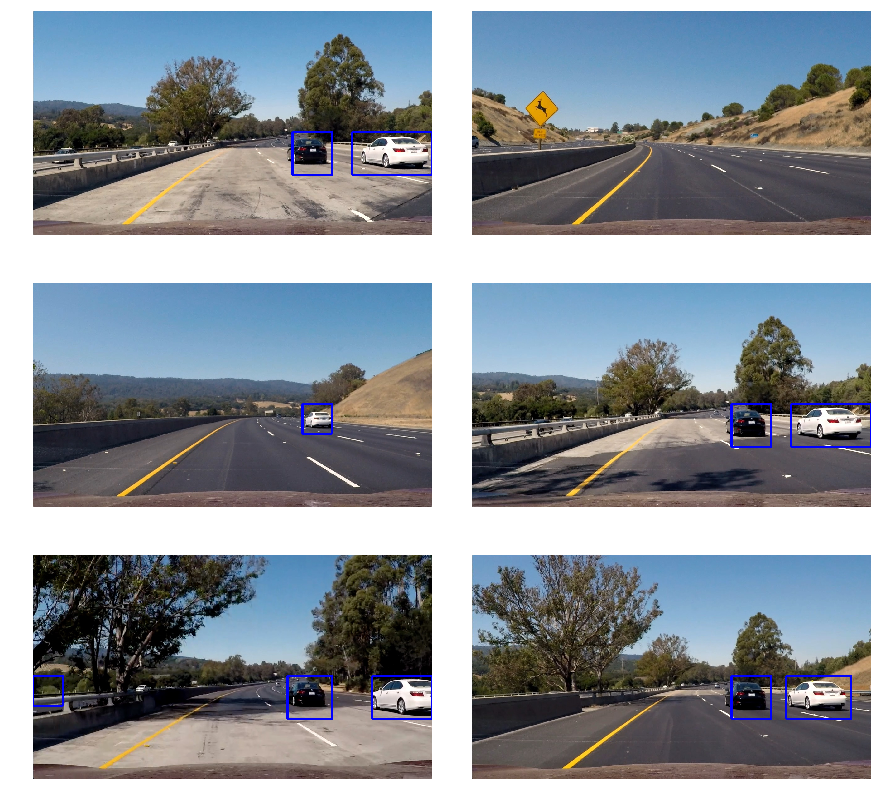

In [18]:
test_images = glob.glob('./test_images/test*.jpg')

plt.clf()
fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.subplots_adjust(hspace = 0.0001, wspace=.1)
axs = axs.ravel()

c=0
for im in test_images:
    image = mpimg.imread(im)
    axs[c].axis("off")
    axs[c].imshow(findCarsInFrame(image))
    c=c+1
    
plt.show()

fig.savefig("./output_images/detection.png")

In [43]:
# Handling Video now

from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(findCarsInFrame)
%time clip_test_out.write_videofile('test_video_out.mp4', audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 17.1 s, sys: 2.91 s, total: 20 s
Wall time: 19.6 s


In [44]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_out.mp4"))

In [20]:
# Defining a class to hold the boxes identified in the frames which are processed

class Box_list():
    def __init__(self):
        
        self.box_list = []
    
    def add_boxes(self, boxes):
        self.box_list.append(boxes)
        if len(self.box_list) > 15:
            # get rid of older sets
            self.box_list = self.box_list[-15:]

    

In [22]:
# Use the class above to store the 'boxes' found in each frame.
# We define a revised findCarsInFrame

def findCarsInVFrame(test_img):
    
    box_list = getProspectiveBoxlist(test_img)
    
    # add detections to the history
    if len(box_list) > 0:
        det.add_boxes(box_list)
    
    
    # initialize a heat image to all zeros
    heat_image = np.zeros_like(test_img[:,:,0]).astype(np.float)
    
    #add heat to the heat_image at the pixels bound by boxes 
    for box in det.box_list:
        heat_image = add_heat(heat_image, box)
    
    # Apply threashold to the final heat_image (this time  the threashold is increased to the length of box_list)
    heat_image = apply_threshold(heat_image, 1+len(det.box_list)//2)
     
    labels = label(heat_image)
    
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

In [96]:
# initialize a fresh empty list for boxes
det = Box_list()

clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(findCarsInVFrame)
%time clip_test_out.write_videofile('test_video_out.mp4', audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 20.3 s, sys: 3.32 s, total: 23.7 s
Wall time: 23 s


In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_out.mp4"))

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# initialize a fresh empty list for boxes
det = Box_list()

project_clip = VideoFileClip('project_video.mp4')#.subclip(10,20)
project_clip_out = project_clip.fl_image(findCarsInVFrame)
%time project_clip_out.write_videofile('project_video_out.mp4', audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 24%|██▍       | 303/1261 [02:40<08:23,  1.90it/s]


 48%|████▊     | 605/1261 [05:20<05:41,  1.92it/s]


 72%|███████▏  | 907/1261 [07:59<03:04,  1.92it/s]


 96%|█████████▌| 1205/1261 [10:38<00:29,  1.87it/s]


100%|█████████▉| 1260/1261 [11:07<00:00,  1.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 10min 14s, sys: 1min 45s, total: 11min 59s
Wall time: 11min 8s


In [30]:
HTML("""
<video width="800" height="400" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))

In [31]:
vidcap = cv2.VideoCapture('project_video_out.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,12000)      # just cue to 20 sec. position
success,image = vidcap.read()
fname = "./output_images/youtube_pic.png"
if success:
    cv2.imwrite(fname, image)     # save frame as JPEG file